# SAC and Behavioral Cloning

In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy. In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import copy

seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Network Structure

In [20]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        hidden_dim = 64
        self.net = nn.Sequential(
            nn.Linear(input_dimension, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dimension),
            output_activation
        )

    def forward(self, input):
        output = None
        output = self.net(input)
        return output

## Replay Buffer

In [4]:
class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent

In [5]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        self.critic_local = Network(self.state_dim, self.action_dim)
        self.critic_local2 = Network(self.state_dim, self.action_dim)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=learning_rate)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=learning_rate)
        self.critic_target = copy.deepcopy(self.critic_local)
        self.critic_target2 = copy.deepcopy(self.critic_local2)

        self.soft_update_target_networks(tau=1.)

        self.actor_local = Network(self.state_dim, self.action_dim, nn.Softmax(dim=1))
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=learning_rate)
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        with torch.no_grad():
            action_probs, log_action_probs = self.get_action_info(next_states_tensor)

            q_target = self.critic_target.forward(next_states_tensor)
            q_target2 = self.critic_target2.forward(next_states_tensor)

            soft_state = (action_probs * (torch.min(q_target, q_target2) - self.alpha * log_action_probs)).sum(dim=1)
            next_q = rewards_tensor + ~done_tensor * self.discount * soft_state

        soft_q = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        soft_q2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)

        criterion = nn.MSELoss(reduction="none")
        critic_error = criterion(soft_q, next_q)
        critic2_error = criterion(soft_q2, next_q)

        critic_loss = critic_error.mean()
        critic2_loss = critic2_error.mean()

        if not self.offline:
            weight_update = [min(error1.item(), error2.item()) for error1, error2 in zip(critic_error, critic2_error)]
            self.replay_buffer.update_weights(weight_update)

        return critic_loss, critic2_loss

    def actor_loss(self, states_tensor, actions_tensor):
        action_probs, log_action_probs = self.get_action_info(states_tensor)

        q_local = self.critic_local(states_tensor)
        q_local2 = self.critic_local2(states_tensor)

        value = self.alpha * log_action_probs - torch.min(q_local, q_local2)
        actor_loss = (action_probs * value).sum(dim=1).mean()

        return actor_loss, log_action_probs

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            critic_loss, critic_loss2 = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            actor_loss, log_action_probs = self.actor_loss(states_tensor, actions_tensor)
            alpha_loss = self.temperature_loss(log_action_probs)

            critic_loss.backward()
            critic_loss2.backward()
            actor_loss.backward()
            alpha_loss.backward()

            self.critic_optimiser.step()
            self.critic_optimiser2.step()
            self.actor_optimiser.step()
            self.alpha_optimiser.step()

            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/500 [00:00<?, ?it/s]/usr

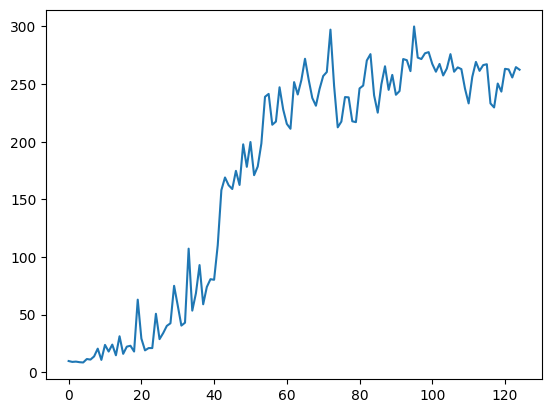

In [21]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 300
env = gym.make("CartPole-v1")

total_results = []
dataset = ReplayBuffer(env)
for run in range(4):
    agent = SACAgent(env, buffer_batch_size=64)
    run_results = []
    for episode in tqdm(range(EPISODES_PER_RUN)):
        ep_reward = 0
        state = env.reset()
        done = False
        is_eval = episode % TRAINING_EVALUATION_RATIO == 0
        step = 0
        while step < STEPS_PER_EPISODE and not done:
            step += 1

            action = agent.get_next_action(state, evaluation_episode=is_eval)
            next_state, reward, done, _ = env.step(action)
            dataset.add_transition((state, action, reward, next_state, done))

            if is_eval:
                ep_reward += reward
            else:
                agent.train_on_transition(state, action, next_state, reward, done)

            state = next_state

        if is_eval:
            run_results.append(ep_reward)

    total_results.append(run_results)

env.close()
results_avg = np.asarray(total_results).mean(axis=0)
plt.plot(results_avg)
plt.show()

In [22]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

## Offline SAC

100%|██████████| 200/200 [1:02:02<00:00, 18.61s/it]


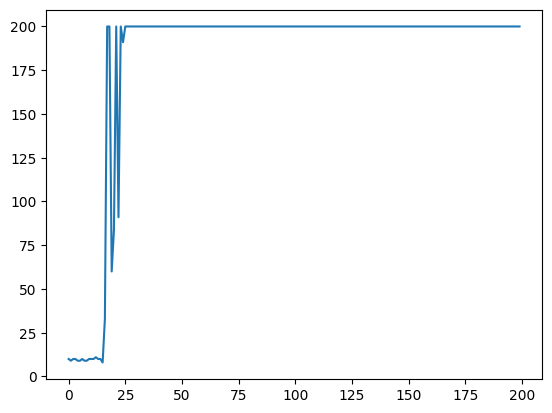

In [39]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 400
STEPS_PER_EPISODE = 200
TRAINING_EVALUATION_RATIO = 1
BATCH_SIZE = 128
env = gym.make("CartPole-v1")

offline_agent = SACAgent(env, replay_buffer=dataset, alpha_init=0.01, offline=True, buffer_batch_size=BATCH_SIZE)
epoch_results = []
for epoch in tqdm(range(NUM_EPOCHS)):
    for episode in range(EPISODES_PER_RUN):
        offline_agent.train_networks()
    ep_reward = 0
    state = env.reset()
    done = False
    step = 0
    while step < STEPS_PER_EPISODE and not done:
        step += 1
        action = offline_agent.get_next_action(state, evaluation_episode=True)
        ep_reward += reward
        state, reward, done, _ = env.step(action)

    epoch_results.append(ep_reward)

env.close()
plt.plot(epoch_results)
plt.show()

In [40]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = offline_agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

 # Behavioural Cloning

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

In [30]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

state_action_pairs = []
for _ in tqdm(range(num_episodes)):
    state = env.reset()
    done = False
    while not done:
        action = agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, done, _ = env.step(action)
        state_action_pairs.append((state, action))
        state = next_state
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


In [48]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        output = self.fc2(F.relu(self.fc1(x)))
        return F.softmax(output, dim=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
bc_model = BCModel(state_dim, 64, action_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bc_model.parameters(), lr=2e-4)

num_epochs = 50
batch_size = 128
bc_model.train()


for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(state_action_pairs), batch_size):
        batch = state_action_pairs[i:i+batch_size]
        states = torch.tensor([state for state, _ in batch])
        actions = torch.tensor([action for _, action in batch])
        optimizer.zero_grad()
        outputs = bc_model(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

Epoch 1/50, Loss: 1302.4789736270905
Epoch 2/50, Loss: 1061.6405933499336
Epoch 3/50, Loss: 1038.7898290455341
Epoch 4/50, Loss: 1030.0504279136658
Epoch 5/50, Loss: 1025.3028017282486
Epoch 6/50, Loss: 1021.9266104400158
Epoch 7/50, Loss: 1018.9290329217911
Epoch 8/50, Loss: 1015.8216678798199
Epoch 9/50, Loss: 1012.2758173942566
Epoch 10/50, Loss: 1007.9636600613594
Epoch 11/50, Loss: 1002.5590259730816
Epoch 12/50, Loss: 996.0012364685535
Epoch 13/50, Loss: 988.6962422132492
Epoch 14/50, Loss: 980.958495259285
Epoch 15/50, Loss: 973.0348530709743
Epoch 16/50, Loss: 965.3534381687641
Epoch 17/50, Loss: 957.9064915180206
Epoch 18/50, Loss: 950.7403783202171
Epoch 19/50, Loss: 943.944033741951
Epoch 20/50, Loss: 937.5728671550751
Epoch 21/50, Loss: 931.6590045392513
Epoch 22/50, Loss: 926.221054494381
Epoch 23/50, Loss: 921.2464279234409
Epoch 24/50, Loss: 916.6976138055325
Epoch 25/50, Loss: 912.5276212096214
Epoch 26/50, Loss: 908.7048543989658
Epoch 27/50, Loss: 905.2041323781013
Ep

In [88]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
bc_model.eval()
state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action = bc_model(state).squeeze(0).argmax().item()
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
